## Классификация изображений

### План семинара:

1) Простая сверточная сеть

2) Методы улучшения качества и скорости сходимости

3) Аугментация

In [1]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

%matplotlib inline
device = 'cuda'

In [2]:
torch.cuda.is_available()

False

Сегодня опять будем работать с датасетом [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), в котором содержатся изображения 10 классов размером 32 на 32 пикселя с тремя каналами. В тренировочной выборке 50000 изображений, а в тестовой 10000.

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./cifar', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
NUM_EPOCH = 25

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

В качестве бейзлайна возьмем сверточную сеть, состоящую из 1 VGG блока.

VGG блок состоит из двух последовательных сверточных слоев с нелинейностью ReLU между ними, а затем max-pooling. В VGG используются маленькие фильтры размера 3x3 и паддинг

### В качестве бейзлайна постройте следующую архитектуру:

1) VGG блок с 16 каналами.

2) Полносвязный слой с 128 выходами и нелинейностью ReLU

3) Полносвязный слой с 10 выходами и Softmax

In [10]:
model_baseline = nn.Sequential(
    ## YOUR CODE
)

In [ ]:
model_baseline.to(device)

## Задание: допишите цикл обучения

In [13]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader):
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []
    
    for epoch in range(NUM_EPOCH):
        model.train()
        train_loss = 0.
        train_size = 0
        train_acc = 0.
        for imgs, labels in train_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            ## YOUR CODE
            y_pred = ## YOUR CODE
            loss = ## YOUR CODE
            ## YOUR CODE
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))

            _, pred_classes = torch.max(y_pred, 1)
            train_acc += (pred_classes == labels).sum().item()
            train_acc_log.append(np.mean((pred_classes == labels).cpu().numpy()))


        val_loss = 0.
        val_size = 0
        val_acc = 0.
        model.eval()
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                imgs, labels = imgs.to(device), labels.to(device)
                pred = model(imgs)
                loss = criterion(pred, labels)
                val_loss += loss.item()
                val_size += pred.size(0)

                _, pred_classes = torch.max(pred, 1)
                val_acc += (pred_classes == labels).sum().item()
        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_acc / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        plot_history(train_acc_log, val_acc_log, 'accuracy')

        print('Train loss:', train_loss / train_size)
        print('Train acc:', train_acc / train_size)
        print('Val loss:', val_loss / val_size)
        print('Val acc:', val_acc / val_size)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)

train(model_baseline, criterion, optimizer, train_dataloader, test_dataloader)

## Задание:

Поэкспериментируйте с функциями активации сети. Попробуйте заменить ReLU на LeakyReLU, ELU или SELU. Как замена влияет на качество и скорость сходимости?

In [ ]:
## YOUR CODE

А пока наша сеть обучается, давайте разберем, как ее можно улучшить. 

Особенность VGG блока заключается в том, что повышение качества работы сети достигается увеличением числа последовательных блоков. При этом число фильтров в каждом новом блоке в два раза больше, чем в предыдущем. Давайте попробуем объединить 3 VGG блока.

Если сеть имеет сложную архитектуру, то возможно переобучение - процесс, в котором модель слишком сильно подстраивается под тренировочную выборку и потом дает заниженное качество на тестовой. Для борьбы с этим будем использовать Dropout

![dropout](dropout.png)

Добавим Dropout с параметром 0.2 после каждого VGG блока и после 1 полносвязного слоя и его нелинейности.

для ускорения и стабилизации обучения добавим BatchNorm после каждого сверточного слоя и после 1 полносвязного слоя


In [8]:
model = nn.Sequential(
    ## YOUR CODE
)

In [ ]:
model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model, criterion, optimizer, train_dataloader, test_dataloader)

### Аугментация

Аугментация данных - очень мощный процесс, который позволяет увеличить количество тренировочных данных. С помощью поворотов, отражения, добавления шума, сдвигов и других преобразований, картинка немного меняется, однако сохраняет свою прежнюю метку. С помощью функции Compose можно объединять несколько трансформаций изображения, а потом применять их при чтении датасета. Полный список аугментаций доступен [тут](https://pytorch.org/docs/stable/torchvision/transforms.html). Изучите его и поэкспериментируйте с различными трансформациями изображения

In [ ]:
def show_dataset(dataset, n=6):
    plt.figure(figsize=(15, 25))
    plt.imshow(np.hstack([np.transpose(np.hstack([img[0] for img in dataset]), (1, 2, 0)) for _ in range(n)]))

In [ ]:
import PIL

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    torchvision.transforms.ToTensor(),
])

In [ ]:
dataset = torchvision.datasets.ImageFolder('data_augmentation/', transform=transforms)

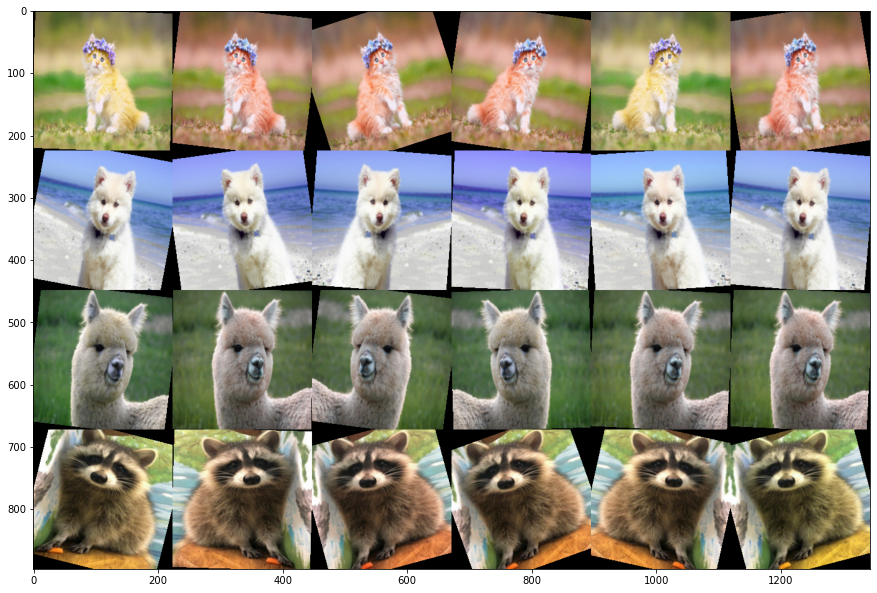

In [ ]:
show_dataset(dataset)